# A Complete Guide to Efficient Transformations of data frames

## Tutorial for JuliaCon 2022
## Bogumił Kamiński

This tutorial will start with simple examples, but gradually we will go into comptex transformations (which I decided to include as typical DataFrames.jl guides show only simple transformations, so I take an opportunity to work through several complex examples today).

Related material covering operation specifixation syntax:
* https://bkamins.github.io/julialang/2020/12/24/minilanguage.html
* https://bkamins.github.io/julialang/2022/05/06/minilanguage.html
* https://bkamins.github.io/julialang/2021/07/09/multicol.html
* https://bkamins.github.io/julialang/2021/01/22/transforming.html
* https://bkamins.github.io/julialang/2022/07/22/juliacon2022.html

This tutorial is not a general introduction to DataFrames.jl, as it focuses only on one aspect of its functionality.

Plese check the https://dataframes.juliadata.org/stable/ link to find a list of itroductory tutorials.

## Introduction

In DataFrames.jl transformations use **operation specification syntax**

This syntax has a general form:

```
[input columns] => [transformation function] => [output columns]
```

Operation specification syntax works on:
* `AbstractDataFrame`
* `GroupedDataFrame`

Functions that support operation specification syntax (versions with `!` are in-place):
* `select`, `select!` (perform operations but keep number and order of rows fixed)
* `transform`, `transform!` (the same as select but keep existing columns)
* `combine` (perform operations and possibly combine rows, and reduce their number)
* `subset`, `subset!` (without output columns)

Eeach of these functions accepts multiple operation specification arguments.

What can be passed as a single operation specficication argument:
* a single operation specification as an argument
* a vector or matrix of Pair operation specifications (`Pair` must be eltype)

Additionally DataFramesMeta.jl allows you to use **assignment style operations**:

```
[output columns] = [transformation expression]
```

In this tutorial I cover both standard **operation specification syntax** from DataFrames.jl and **assignment style operations** from DataFramesMeta.jl. (You can also consider checking-out DataFrameMacros.jl that provides an alternative similar functionality)

## Getting started

We will use a subsetted version of https://database.lichess.org/#puzzles database.

First load the required packages

In [1]:
using DataFramesMeta # this also brings DataFrames.jl into scope

In [2]:
using Parquet2 # to read in the source data; I use Parquet format because it is compressed

In [3]:
using Statistics # bring in common statistical functions to scope like mean or std

In [4]:
using CategoricalArrays # for cut

In [5]:
using GLM # we will want to estimate a linear regression

In [6]:
using Plots # we will do some plotting

In [7]:
using HypothesisTests # we will do some hypothesis testing

Load the source data

In [8]:
ds = Parquet2.Dataset("puzzles.parquet")

≔ Parquet2.Dataset (10280073 bytes)
	1. "Moves": String
	2. "Rating": Int64
	3. "Popularity": Int64
	4. "NbPlays": Int64
	5. "Themes": String
	6. "OpeningFamily": String


In [9]:
df = DataFrame(ds)

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,b6c5 e2g4 h3g4 d1g4,1088,85,505,advantage middlegame short,Kings_Pawn_Game
2,g5e7 a5c3 b2c3 c6e7,1457,86,482,advantage master middlegame short,Benoni_Defense
3,e8f7 e2e6 f7f8 e6f7,1595,88,448,mate mateIn2 middlegame short,Horwitz_Defense
4,d8f6 d1h5 h7h6 h5c5,1762,90,1572,advantage middlegame short,Scotch_Game
5,c7a8 a5c3,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,Sicilian_Defense
6,h2g3 g6h5,1490,50,12,mate mateIn1 oneMove,Ruy_Lopez
7,f2f3 d6c5 g1h1 c5c4,943,96,1091,advantage fork master masterVsMaster middlegame short,Pirc_Defense
8,d3a6 b6c5 a6c8 c5c4,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,Slav_Defense
9,b1c3 f5g4 h5g4 d7g4,1628,96,12910,advantage opening short trappedPiece,Queens_Pawn_Game


## Walk before you run: column selection

In the examples we will show both DataFrames.jl and DataFramesMeta.jl styles.

Get a single column:

In [10]:
select(df, :Themes)

Row,Themes
,String
1,advantage middlegame short
2,advantage master middlegame short
3,mate mateIn2 middlegame short
4,advantage middlegame short
5,bodenMate hangingPiece mate mateIn1 middlegame oneMove
6,mate mateIn1 oneMove
7,advantage fork master masterVsMaster middlegame short
8,crushing master masterVsMaster middlegame sacrifice short
9,advantage opening short trappedPiece


In [11]:
@select(df, :Themes)

Row,Themes
,String
1,advantage middlegame short
2,advantage master middlegame short
3,mate mateIn2 middlegame short
4,advantage middlegame short
5,bodenMate hangingPiece mate mateIn1 middlegame oneMove
6,mate mateIn1 oneMove
7,advantage fork master masterVsMaster middlegame short
8,crushing master masterVsMaster middlegame sacrifice short
9,advantage opening short trappedPiece


Select multiple columns

In [12]:
select(df, "Themes", 4, [:Rating, :Moves])

Row,Themes,NbPlays,Rating,Moves
,String,Int64,Int64,String
1,advantage middlegame short,505,1088,b6c5 e2g4 h3g4 d1g4
2,advantage master middlegame short,482,1457,g5e7 a5c3 b2c3 c6e7
3,mate mateIn2 middlegame short,448,1595,e8f7 e2e6 f7f8 e6f7
4,advantage middlegame short,1572,1762,d8f6 d1h5 h7h6 h5c5
5,bodenMate hangingPiece mate mateIn1 middlegame oneMove,136,1013,c7a8 a5c3
6,mate mateIn1 oneMove,12,1490,h2g3 g6h5
7,advantage fork master masterVsMaster middlegame short,1091,943,f2f3 d6c5 g1h1 c5c4
8,crushing master masterVsMaster middlegame sacrifice short,639,1927,d3a6 b6c5 a6c8 c5c4
9,advantage opening short trappedPiece,12910,1628,b1c3 f5g4 h5g4 d7g4


In [13]:
@select(df, :Themes, :NbPlays, :Rating, :Moves)

Row,Themes,NbPlays,Rating,Moves
,String,Int64,Int64,String
1,advantage middlegame short,505,1088,b6c5 e2g4 h3g4 d1g4
2,advantage master middlegame short,482,1457,g5e7 a5c3 b2c3 c6e7
3,mate mateIn2 middlegame short,448,1595,e8f7 e2e6 f7f8 e6f7
4,advantage middlegame short,1572,1762,d8f6 d1h5 h7h6 h5c5
5,bodenMate hangingPiece mate mateIn1 middlegame oneMove,136,1013,c7a8 a5c3
6,mate mateIn1 oneMove,12,1490,h2g3 g6h5
7,advantage fork master masterVsMaster middlegame short,1091,943,f2f3 d6c5 g1h1 c5c4
8,crushing master masterVsMaster middlegame sacrifice short,639,1927,d3a6 b6c5 a6c8 c5c4
9,advantage opening short trappedPiece,12910,1628,b1c3 f5g4 h5g4 d7g4


Normally `@select` expects symbols; you can pass other arguments accepted by `select` verbatim by escaping them with `$`.

In [14]:
@select(df, $"Themes", $4, $[:Rating, :Moves])

Row,Themes,NbPlays,Rating,Moves
,String,Int64,Int64,String
1,advantage middlegame short,505,1088,b6c5 e2g4 h3g4 d1g4
2,advantage master middlegame short,482,1457,g5e7 a5c3 b2c3 c6e7
3,mate mateIn2 middlegame short,448,1595,e8f7 e2e6 f7f8 e6f7
4,advantage middlegame short,1572,1762,d8f6 d1h5 h7h6 h5c5
5,bodenMate hangingPiece mate mateIn1 middlegame oneMove,136,1013,c7a8 a5c3
6,mate mateIn1 oneMove,12,1490,h2g3 g6h5
7,advantage fork master masterVsMaster middlegame short,1091,943,f2f3 d6c5 g1h1 c5c4
8,crushing master masterVsMaster middlegame sacrifice short,639,1927,d3a6 b6c5 a6c8 c5c4
9,advantage opening short trappedPiece,12910,1628,b1c3 f5g4 h5g4 d7g4


In [15]:
@macroexpand @select(df, $"Themes", $4, $[:Rating, :Moves])

quote
    #= C:\Users\bogum\.julia\packages\DataFramesMeta\hLirN\src\macros.jl:1791 =#
    (DataFrames.select)(df, "Themes", 4, [:Rating, :Moves]; )
end

### Recommendation:

* *DataFramesMeta.jl* style is usually more convenient for "static code" where column names are fixed and known and is easier to learn.
* *DataFrames.jl* style is usually more convenient for "dynamic code" where column names are dynamically generated, but is slightly more verbose.

<div class="alert alert-block alert-info">
Since different users have different preferences and requirements we provide both options in the ecosystem.

In this tutorial I show you both versions so that you can decide which one is more convenient for you (of course you can mix both styles if you wanted).
</div>

## Special column selectors

Dropping columns

In [16]:
select(df, Not(:Themes))

Row,Moves,Rating,Popularity,NbPlays,OpeningFamily
,String,Int64,Int64,Int64,String
1,b6c5 e2g4 h3g4 d1g4,1088,85,505,Kings_Pawn_Game
2,g5e7 a5c3 b2c3 c6e7,1457,86,482,Benoni_Defense
3,e8f7 e2e6 f7f8 e6f7,1595,88,448,Horwitz_Defense
4,d8f6 d1h5 h7h6 h5c5,1762,90,1572,Scotch_Game
5,c7a8 a5c3,1013,39,136,Sicilian_Defense
6,h2g3 g6h5,1490,50,12,Ruy_Lopez
7,f2f3 d6c5 g1h1 c5c4,943,96,1091,Pirc_Defense
8,d3a6 b6c5 a6c8 c5c4,1927,93,639,Slav_Defense
9,b1c3 f5g4 h5g4 d7g4,1628,96,12910,Queens_Pawn_Game


Getting some range of columns

In [17]:
select(df, Between("Rating", "NbPlays"))

Row,Rating,Popularity,NbPlays
,Int64,Int64,Int64
1,1088,85,505
2,1457,86,482
3,1595,88,448
4,1762,90,1572
5,1013,39,136
6,1490,50,12
7,943,96,1091
8,1927,93,639
9,1628,96,12910


Selecting columns whose names match some regex pattern.

In [18]:
select(df, r"P")

Row,Popularity,NbPlays
,Int64,Int64
1,85,505
2,86,482
3,88,448
4,90,1572
5,39,136
6,50,12
7,96,1091
8,93,639
9,96,12910


Selecting columns whose names meet some predicate.

In [19]:
select(df, Cols(endswith("s")))

Row,Moves,NbPlays,Themes
,String,Int64,String
1,b6c5 e2g4 h3g4 d1g4,505,advantage middlegame short
2,g5e7 a5c3 b2c3 c6e7,482,advantage master middlegame short
3,e8f7 e2e6 f7f8 e6f7,448,mate mateIn2 middlegame short
4,d8f6 d1h5 h7h6 h5c5,1572,advantage middlegame short
5,c7a8 a5c3,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove
6,h2g3 g6h5,12,mate mateIn1 oneMove
7,f2f3 d6c5 g1h1 c5c4,1091,advantage fork master masterVsMaster middlegame short
8,d3a6 b6c5 a6c8 c5c4,639,crushing master masterVsMaster middlegame sacrifice short
9,b1c3 f5g4 h5g4 d7g4,12910,advantage opening short trappedPiece


How to drop a column that you may be present or not in a data frame?

Just using `Not` fails.

In [20]:
select(df, Not(:X))

LoadError: ArgumentError: column name :X not found in the data frame

but you can combine it with `Cols` selector:

In [21]:
select(df, Not(Cols(==("X"))))

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,b6c5 e2g4 h3g4 d1g4,1088,85,505,advantage middlegame short,Kings_Pawn_Game
2,g5e7 a5c3 b2c3 c6e7,1457,86,482,advantage master middlegame short,Benoni_Defense
3,e8f7 e2e6 f7f8 e6f7,1595,88,448,mate mateIn2 middlegame short,Horwitz_Defense
4,d8f6 d1h5 h7h6 h5c5,1762,90,1572,advantage middlegame short,Scotch_Game
5,c7a8 a5c3,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,Sicilian_Defense
6,h2g3 g6h5,1490,50,12,mate mateIn1 oneMove,Ruy_Lopez
7,f2f3 d6c5 g1h1 c5c4,943,96,1091,advantage fork master masterVsMaster middlegame short,Pirc_Defense
8,d3a6 b6c5 a6c8 c5c4,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,Slav_Defense
9,b1c3 f5g4 h5g4 d7g4,1628,96,12910,advantage opening short trappedPiece,Queens_Pawn_Game


## Column renaming

If you only need to rename columns use `rename` or `rename!`.

However, often some columns need renaming while other need to be dropped or transformed in the same operation.

Therefore **operation transformation specification** allows for column renaming.

In [22]:
select(df, :Themes => :Theme)

Row,Theme
,String
1,advantage middlegame short
2,advantage master middlegame short
3,mate mateIn2 middlegame short
4,advantage middlegame short
5,bodenMate hangingPiece mate mateIn1 middlegame oneMove
6,mate mateIn1 oneMove
7,advantage fork master masterVsMaster middlegame short
8,crushing master masterVsMaster middlegame sacrifice short
9,advantage opening short trappedPiece


Below we start being more fancy since we use a function to rename multiple columns (you can skip this example when working with this tutorial for the first time):

In [23]:
select(df, Cols(endswith("s")) .=> identity .=> uppercase)

Row,MOVES,NBPLAYS,THEMES
,String,Int64,String
1,b6c5 e2g4 h3g4 d1g4,505,advantage middlegame short
2,g5e7 a5c3 b2c3 c6e7,482,advantage master middlegame short
3,e8f7 e2e6 f7f8 e6f7,448,mate mateIn2 middlegame short
4,d8f6 d1h5 h7h6 h5c5,1572,advantage middlegame short
5,c7a8 a5c3,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove
6,h2g3 g6h5,12,mate mateIn1 oneMove
7,f2f3 d6c5 g1h1 c5c4,1091,advantage fork master masterVsMaster middlegame short
8,d3a6 b6c5 a6c8 c5c4,639,crushing master masterVsMaster middlegame sacrifice short
9,b1c3 f5g4 h5g4 d7g4,12910,advantage opening short trappedPiece


The operations that we do here are a bit advanced:
* DataFrames.jl is able to dynamically identify the columns selected by `Cols(endswith("s"))` and, using broadcasting, apply the requested operations to all of them
* in the `[input columns] => [transformation function] => [output columns]` syntax `[output columns]` can be a function that dynamically generates the output column name based on the passed `[input columns]`, however, to use it in renaming we need to pass `[transformation function]` as `identity` (essentially no-op), as wihout it DataFrames.jl would think that `uppercase` is transformation function.

## Commonly used selection patterns

Move column to the first position:

In [24]:
select(df, :OpeningFamily, :)

Row,OpeningFamily,Moves,Rating,Popularity,NbPlays,Themes
,String,String,Int64,Int64,Int64,String
1,Kings_Pawn_Game,b6c5 e2g4 h3g4 d1g4,1088,85,505,advantage middlegame short
2,Benoni_Defense,g5e7 a5c3 b2c3 c6e7,1457,86,482,advantage master middlegame short
3,Horwitz_Defense,e8f7 e2e6 f7f8 e6f7,1595,88,448,mate mateIn2 middlegame short
4,Scotch_Game,d8f6 d1h5 h7h6 h5c5,1762,90,1572,advantage middlegame short
5,Sicilian_Defense,c7a8 a5c3,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove
6,Ruy_Lopez,h2g3 g6h5,1490,50,12,mate mateIn1 oneMove
7,Pirc_Defense,f2f3 d6c5 g1h1 c5c4,943,96,1091,advantage fork master masterVsMaster middlegame short
8,Slav_Defense,d3a6 b6c5 a6c8 c5c4,1927,93,639,crushing master masterVsMaster middlegame sacrifice short
9,Queens_Pawn_Game,b1c3 f5g4 h5g4 d7g4,1628,96,12910,advantage opening short trappedPiece


Move column to the end:

In [25]:
select(df, Not(:Moves), :Moves)

Row,Rating,Popularity,NbPlays,Themes,OpeningFamily,Moves
,Int64,Int64,Int64,String,String,String
1,1088,85,505,advantage middlegame short,Kings_Pawn_Game,b6c5 e2g4 h3g4 d1g4
2,1457,86,482,advantage master middlegame short,Benoni_Defense,g5e7 a5c3 b2c3 c6e7
3,1595,88,448,mate mateIn2 middlegame short,Horwitz_Defense,e8f7 e2e6 f7f8 e6f7
4,1762,90,1572,advantage middlegame short,Scotch_Game,d8f6 d1h5 h7h6 h5c5
5,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,Sicilian_Defense,c7a8 a5c3
6,1490,50,12,mate mateIn1 oneMove,Ruy_Lopez,h2g3 g6h5
7,943,96,1091,advantage fork master masterVsMaster middlegame short,Pirc_Defense,f2f3 d6c5 g1h1 c5c4
8,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,Slav_Defense,d3a6 b6c5 a6c8 c5c4
9,1628,96,12910,advantage opening short trappedPiece,Queens_Pawn_Game,b1c3 f5g4 h5g4 d7g4


Do both:

In [26]:
select(df, :OpeningFamily, Not(:Moves), :Moves)

Row,OpeningFamily,Rating,Popularity,NbPlays,Themes,Moves
,String,Int64,Int64,Int64,String,String
1,Kings_Pawn_Game,1088,85,505,advantage middlegame short,b6c5 e2g4 h3g4 d1g4
2,Benoni_Defense,1457,86,482,advantage master middlegame short,g5e7 a5c3 b2c3 c6e7
3,Horwitz_Defense,1595,88,448,mate mateIn2 middlegame short,e8f7 e2e6 f7f8 e6f7
4,Scotch_Game,1762,90,1572,advantage middlegame short,d8f6 d1h5 h7h6 h5c5
5,Sicilian_Defense,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,c7a8 a5c3
6,Ruy_Lopez,1490,50,12,mate mateIn1 oneMove,h2g3 g6h5
7,Pirc_Defense,943,96,1091,advantage fork master masterVsMaster middlegame short,f2f3 d6c5 g1h1 c5c4
8,Slav_Defense,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,d3a6 b6c5 a6c8 c5c4
9,Queens_Pawn_Game,1628,96,12910,advantage opening short trappedPiece,b1c3 f5g4 h5g4 d7g4


When you pick multiple columns duplicate column names are allowed, but not in operations that generate single columns:

In [27]:
select(df, Between(3, 5), Between(1, 3))

Row,Popularity,NbPlays,Themes,Moves,Rating
,Int64,Int64,String,String,Int64
1,85,505,advantage middlegame short,b6c5 e2g4 h3g4 d1g4,1088
2,86,482,advantage master middlegame short,g5e7 a5c3 b2c3 c6e7,1457
3,88,448,mate mateIn2 middlegame short,e8f7 e2e6 f7f8 e6f7,1595
4,90,1572,advantage middlegame short,d8f6 d1h5 h7h6 h5c5,1762
5,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,c7a8 a5c3,1013
6,50,12,mate mateIn1 oneMove,h2g3 g6h5,1490
7,96,1091,advantage fork master masterVsMaster middlegame short,f2f3 d6c5 g1h1 c5c4,943
8,93,639,crushing master masterVsMaster middlegame sacrifice short,d3a6 b6c5 a6c8 c5c4,1927
9,96,12910,advantage opening short trappedPiece,b1c3 f5g4 h5g4 d7g4,1628


In [28]:
select(df, :Themes, :Themes)

LoadError: ArgumentError: duplicate output column name: :Themes

In [29]:
select(df, :Themes => :x, :Moves => :x)

LoadError: ArgumentError: duplicate output column name: :x

## Jogging: operations on a single column of a data frame

Let us check out several ways to do the following operation: calculate mean rating of puzzles.

Start with a full syntax.

In [30]:
combine(df, :Rating => mean => :Rating_mean)

Row,Rating_mean
,Float64
1,1578.6


You can drop output column name to automatically generate one.

In [31]:
combine(df, :Rating => mean)

Row,Rating_mean
,Float64
1,1578.6


Use a function to automatically generate output column name.

In [32]:
combine(df, :Rating => mean => x -> x * "_mean")

Row,Rating_mean
,Float64
1,1578.6


use DataFramesMeta.jl:

In [33]:
@combine(df, :Rating_mean = mean(:Rating))

Row,Rating_mean
,Float64
1,1578.6


Note that `combine` combines multiple rows of the source data frame into one. If we used `select` we the result would be expanded into as many rows as were present in the source data frame.

In [34]:
select(df, :Rating => mean)

Row,Rating_mean
,Float64
1,1578.6
2,1578.6
3,1578.6
4,1578.6
5,1578.6
6,1578.6
7,1578.6
8,1578.6
9,1578.6


In [35]:
@select(df, :Rating_mean = mean(:Rating))

Row,Rating_mean
,Float64
1,1578.6
2,1578.6
3,1578.6
4,1578.6
5,1578.6
6,1578.6
7,1578.6
8,1578.6
9,1578.6


### Important rule
* `combine` *combines* rows, which means it changes number of rows (and possibly order if you work with `GroupedDataFrame`) for a source data frame.
* `select[!]` and `transform[!]` always keep the number and order of rows of a source data frame.

Now let us do a more complex task. Add a new column to a data frame with number of moves in the puzzle.
We notice that consecutive moves are separated by a space in `:Moves` column.

In DataFrames.jl we use the `ByRow` wrapper which automatically broadcasts the passed function.

We use `transform` to keep all existing columns and add a new one at the end:

In [36]:
transform(df, :Moves => ByRow(x -> 1 + count(==(' '), x)) => :MoveNo)

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily,MoveNo
,String,Int64,Int64,Int64,String,String,Int64
1,b6c5 e2g4 h3g4 d1g4,1088,85,505,advantage middlegame short,Kings_Pawn_Game,4
2,g5e7 a5c3 b2c3 c6e7,1457,86,482,advantage master middlegame short,Benoni_Defense,4
3,e8f7 e2e6 f7f8 e6f7,1595,88,448,mate mateIn2 middlegame short,Horwitz_Defense,4
4,d8f6 d1h5 h7h6 h5c5,1762,90,1572,advantage middlegame short,Scotch_Game,4
5,c7a8 a5c3,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,Sicilian_Defense,2
6,h2g3 g6h5,1490,50,12,mate mateIn1 oneMove,Ruy_Lopez,2
7,f2f3 d6c5 g1h1 c5c4,943,96,1091,advantage fork master masterVsMaster middlegame short,Pirc_Defense,4
8,d3a6 b6c5 a6c8 c5c4,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,Slav_Defense,4
9,b1c3 f5g4 h5g4 d7g4,1628,96,12910,advantage opening short trappedPiece,Queens_Pawn_Game,4


In DataFramesMeta.jl we prefix the macro name with `r` to make it work by row.

Such transformations like the one we work with right now are typically more conveniently written using DataFamesMeta.jl.

In [37]:
@rtransform(df, :MoveNo = 1 + count(==(' '), :Moves))

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily,MoveNo
,String,Int64,Int64,Int64,String,String,Int64
1,b6c5 e2g4 h3g4 d1g4,1088,85,505,advantage middlegame short,Kings_Pawn_Game,4
2,g5e7 a5c3 b2c3 c6e7,1457,86,482,advantage master middlegame short,Benoni_Defense,4
3,e8f7 e2e6 f7f8 e6f7,1595,88,448,mate mateIn2 middlegame short,Horwitz_Defense,4
4,d8f6 d1h5 h7h6 h5c5,1762,90,1572,advantage middlegame short,Scotch_Game,4
5,c7a8 a5c3,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,Sicilian_Defense,2
6,h2g3 g6h5,1490,50,12,mate mateIn1 oneMove,Ruy_Lopez,2
7,f2f3 d6c5 g1h1 c5c4,943,96,1091,advantage fork master masterVsMaster middlegame short,Pirc_Defense,4
8,d3a6 b6c5 a6c8 c5c4,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,Slav_Defense,4
9,b1c3 f5g4 h5g4 d7g4,1628,96,12910,advantage opening short trappedPiece,Queens_Pawn_Game,4


Now it is time to start working with `GroupedDataFrame`.

Let us continue the previous example and calculate mean puzzle rating and popularity as a function of number of moves (this is a more advanced example, you might want to skip it on the first pass through this notebook).

In the example we use the `@chain` macro (which gets imported when we use DataFramesMeta.jl, but it is originaly defined in Chain.jl).
In its simplest form it allows to chain several operations together the result of the previous operation is passed as a first argument to the next operation (and it can be skipped).

In the example we additionaly use a special form of operation specification:
* `nrow` returns a number of rows in a data frame (or a group) and creates `:nrow` column;
* `nrow => :custom_column_name` does the same but allows you to pass a custom column name (`:custom_column_name` in the example)

In case of `@rtransform` since this is a transformation not having an assignment form we need to escape it with `$`.

In [38]:
@chain df begin
    @rtransform(:MoveNo = 1 + count(==(' '), :Moves))
    groupby(:MoveNo, sort=true)
    @combine($nrow,
             :Rating_mean = mean(:Rating),
             :Popularity_mean = mean(:Popularity))
end

Row,MoveNo,nrow,Rating_mean,Popularity_mean
,Int64,Int64,Float64,Float64
1,2,48933,1173.67,74.6678
2,4,357884,1505.63,81.7749
3,6,129576,1814.91,85.5729
4,8,22687,2065.25,84.2806
5,10,4492,2249.31,82.3771
6,12,1068,2357.96,80.3446
7,14,343,2426.43,78.5335
8,16,104,2408.8,76.9615
9,18,25,2470.04,84.16


In this case using DataFrames.jl syntax is more compact:

In [39]:
@chain df begin
    transform(:Moves => ByRow(x -> 1 + count(==(' '), x)) => :MoveNo)
    groupby(:MoveNo, sort=true)
    combine(nrow, [:Rating, :Popularity] .=> mean)
end

Row,MoveNo,nrow,Rating_mean,Popularity_mean
,Int64,Int64,Float64,Float64
1,2,48933,1173.67,74.6678
2,4,357884,1505.63,81.7749
3,6,129576,1814.91,85.5729
4,8,22687,2065.25,84.2806
5,10,4492,2249.31,82.3771
6,12,1068,2357.96,80.3446
7,14,343,2426.43,78.5335
8,16,104,2408.8,76.9615
9,18,25,2470.04,84.16


Let us do a siplmer `groupby` aggregation to practice it more.

We want to check average `:NbPlays` by opening:

In [40]:
gdf = groupby(df, :OpeningFamily, sort=true)

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,c4b6 e4c5 b6a4 c5a4,1245,88,575,crushing middlegame short,Alekhine_Defense
2,b1c3 d5d4 b3b5 e6d7 b5d3 d4c3,1258,90,1417,crushing defensiveMove long middlegame,Alekhine_Defense
3,d5c7 e7b4 e1d1 e8e1,1543,81,65,doubleCheck mate mateIn2 opening short,Alekhine_Defense
4,e7g5 f3f5 g7g6 f5g5,1986,76,40,crushing middlegame short,Alekhine_Defense
5,f5c2 d2c4 d5c4 e2c2,1420,96,13207,advantage discoveredAttack middlegame short,Alekhine_Defense
6,f4h6 d3h7 e1e3 h7h6,2461,83,98,advantage master middlegame short,Alekhine_Defense
7,f1b5 d8a5 e1f2 a5b5,1500,100,0,crushing fork short,Alekhine_Defense
8,h8g8 d1h5 e8e7 f5f6 g7f6 g1h1,1772,81,271,crushing defensiveMove exposedKing fork long middlegame,Alekhine_Defense
9,f3d4 d8h4 e2f2 h4d4 f2f6 e3g2 e1e2 d4g4,2364,88,731,advantage exposedKing fork middlegame veryLong,Alekhine_Defense


In [41]:
combine(gdf, :NbPlays => mean)

Row,OpeningFamily,NbPlays_mean
,String,Float64
1,Alekhine_Defense,1053.93
2,Amar_Gambit,206.0
3,Amar_Opening,626.05
4,Amazon_Attack,483.541
5,Anderssens_Opening,1061.28
6,Australian_Defense,1317.0
7,Barnes_Defense,1006.73
8,Barnes_Opening,610.041
9,Benko_Gambit,1114.18


In [42]:
@combine(gdf, :Nb_Plays_mean = mean(:NbPlays))

Row,OpeningFamily,Nb_Plays_mean
,String,Float64
1,Alekhine_Defense,1053.93
2,Amar_Gambit,206.0
3,Amar_Opening,626.05
4,Amazon_Attack,483.541
5,Anderssens_Opening,1061.28
6,Australian_Defense,1317.0
7,Barnes_Defense,1006.73
8,Barnes_Opening,610.041
9,Benko_Gambit,1114.18


It would be nice to have the results sorted, so:

In [43]:
@chain gdf begin
    @combine(:Nb_Plays_mean = mean(:NbPlays))
    sort(:Nb_Plays_mean, rev=true)
end

Row,OpeningFamily,Nb_Plays_mean
,String,Float64
1,Blackmar-Diemer_Lemberger_Countergambit,4128.33
2,Vulture_Defense,2746.11
3,Global_Opening,2059.4
4,Crab_Opening,1696.53
5,Latvian_Gambit,1610.16
6,Guatemala_Defense,1539.2
7,Ware_Opening,1480.5
8,Bronstein_Gambit,1418.75
9,Kangaroo_Defense,1342.45


Often you want to do aggregation by binned variable. Here `cut` from CategoricalArrays.jl is useful:

In [44]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => mean)
end

Row,Popularity_10,Rating_mean
,Cat…,Float64
1,"Q1: [-100.0, 65.0)",1498.09
2,"Q2: [65.0, 78.0)",1592.56
3,"Q3: [78.0, 83.0)",1650.06
4,"Q4: [83.0, 86.0)",1688.62
5,"Q5: [86.0, 89.0)",1651.15
6,"Q6: [89.0, 92.0)",1703.36
7,"Q7: [92.0, 93.0)",1628.76
8,"Q8: [93.0, 95.0)",1531.27
9,"Q9: [95.0, 99.0)",1480.38


In [45]:
@chain df begin
    @transform(:Popularity_10 = cut(:Popularity, 10))
    groupby(:Popularity_10)
    @combine(:Rating_mean = mean(:Rating))
end

Row,Popularity_10,Rating_mean
,Cat…,Float64
1,"Q1: [-100.0, 65.0)",1498.09
2,"Q2: [65.0, 78.0)",1592.56
3,"Q3: [78.0, 83.0)",1650.06
4,"Q4: [83.0, 86.0)",1688.62
5,"Q5: [86.0, 89.0)",1651.15
6,"Q6: [89.0, 92.0)",1703.36
7,"Q7: [92.0, 93.0)",1628.76
8,"Q8: [93.0, 95.0)",1531.27
9,"Q9: [95.0, 99.0)",1480.38


What if we wanted quantiles of rating instead?

In [46]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating .=> [x -> quantile(x, q) for q in [0.25, 0.5, 0.75]] .=> string.("Rating", 25:25:75))
end

Row,Popularity_10,Rating25,Rating50,Rating75
,Cat…,Float64,Float64,Float64
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


In [47]:
@chain df begin
    @transform(:Popularity_10 = cut(:Popularity, 10))
    groupby(:Popularity_10)
    @combine(:Rating25 = quantile(:Rating, 0.25),
             :Rating5 = quantile(:Rating, 0.5),
             :Rating75 = quantile(:Rating, 0.75))
end

Row,Popularity_10,Rating25,Rating5,Rating75
,Cat…,Float64,Float64,Float64
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


But `quantile` accepts a vector of quantiles:

In [48]:
quantile(df.Rating, [0.25, 0.5, 0.75])

3-element Vector{Float64}:
 1241.0
 1544.0
 1889.0

Can we take advantage of this?

A simple approach is problematic:

In [49]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => x -> quantile(x, [0.25, 0.5, 0.75]))
end

Row,Popularity_10,Rating_function
,Cat…,Float64
1,"Q1: [-100.0, 65.0)",1204.0
2,"Q1: [-100.0, 65.0)",1457.0
3,"Q1: [-100.0, 65.0)",1748.0
4,"Q2: [65.0, 78.0)",1267.0
5,"Q2: [65.0, 78.0)",1557.0
6,"Q2: [65.0, 78.0)",1905.0
7,"Q3: [78.0, 83.0)",1325.0
8,"Q3: [78.0, 83.0)",1629.0
9,"Q3: [78.0, 83.0)",1982.0


What is the problem? `combine` produces three values per group. Since `quantile` returns a vector we get three rows per group in the output.

There are several approaches to fix it.

The first is to protect the vector using `Ref`.

In [50]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> Ref(quantile(x, [0.25, 0.5, 0.75]))))
end

Row,Popularity_10,Rating_function
,Cat…,Array…
1,"Q1: [-100.0, 65.0)","[1204.0, 1457.0, 1748.0]"
2,"Q2: [65.0, 78.0)","[1267.0, 1557.0, 1905.0]"
3,"Q3: [78.0, 83.0)","[1325.0, 1629.0, 1982.0]"
4,"Q4: [83.0, 86.0)","[1366.0, 1670.5, 2009.0]"
5,"Q5: [86.0, 89.0)","[1317.0, 1639.0, 1958.0]"
6,"Q6: [89.0, 92.0)","[1259.0, 1699.0, 2126.0]"
7,"Q7: [92.0, 93.0)","[1296.0, 1628.0, 1948.0]"
8,"Q8: [93.0, 95.0)","[1201.0, 1517.0, 1799.0]"
9,"Q9: [95.0, 99.0)","[1132.0, 1482.0, 1772.0]"


With `Ref` return value is sotred "as is" as one row. We can now expand it into multiple columns in a second step.

For this we specify multiple columns in the output.

What can be expanded into multiple columns? Here is the list:
* one of: `AbstractDataFrame`, `NamedTuple`, `DataFrameRow`, `AbstractMatrix`;
* if function returns an `AbstractVector` then each element of this vector must support the `keys` function, which must return a collection of `Symbols`, strings or integers; the return value of keys must be identical for all elements. Then as many columns are created as there are elements in the return value of the keys function;
* if function returns a value of any other type then it is assumed that it is a table conforming to the Tables.jl API and the `Tables.columntable` function is called on it.

In [51]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> Ref(quantile(x, [0.25, 0.5, 0.75]))))
    select(:Popularity_10, :Rating_function => string.("Rating", 25:25:75))
end

Row,Popularity_10,Rating25,Rating50,Rating75
,Cat…,Float64,Float64,Float64
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


Passing `AsTable` instead of a vector of column names does autogeneration of column names:

In [52]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> Ref(quantile(x, [0.25, 0.5, 0.75]))))
    select(:Popularity_10, :Rating_function => AsTable)
end

Row,Popularity_10,x1,x2,x3
,Cat…,Float64,Float64,Float64
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


The other approach is to do the operation in "one shot".

This time instead of using `Ref`, we wrap a vector in a vector (so we get a one-element vector holding a vector which can be expanded following the rules described above):

In [53]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> [quantile(x, [0.25, 0.5, 0.75])]) => string.("Rating", 25:25:75))
end

Row,Popularity_10,Rating25,Rating50,Rating75
,Cat…,Float64,Float64,Float64
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


The last approach we discuss is to use `NamedTuple`. We will do it in two ways.

The first is also in "one shot". In it we use a `(; :name => value, ...)` style to create `NamedTuple`.

Note that in this case `AsTable` uses column names from `NamedTuple`.

In [54]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> (; (Symbol.("Rating", 25:25:75) .=> quantile(x, [0.25, 0.5, 0.75]))...)) => AsTable)
end

Row,Popularity_10,Rating25,Rating50,Rating75
,Cat…,Float64,Float64,Float64
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


The second approach is in two steps but a bit simpler. First we create three rows per group, and next we unstack the table:

In [55]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> (name=string.("Rating", 25:25:75), value=quantile(x, [0.25, 0.5, 0.75]))) => AsTable)
end

Row,Popularity_10,name,value
,Cat…,String,Float64
1,"Q1: [-100.0, 65.0)",Rating25,1204.0
2,"Q1: [-100.0, 65.0)",Rating50,1457.0
3,"Q1: [-100.0, 65.0)",Rating75,1748.0
4,"Q2: [65.0, 78.0)",Rating25,1267.0
5,"Q2: [65.0, 78.0)",Rating50,1557.0
6,"Q2: [65.0, 78.0)",Rating75,1905.0
7,"Q3: [78.0, 83.0)",Rating25,1325.0
8,"Q3: [78.0, 83.0)",Rating50,1629.0
9,"Q3: [78.0, 83.0)",Rating75,1982.0


In [56]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 10)) => :Popularity_10)
    groupby(:Popularity_10)
    combine(:Rating => (x -> (name=string.("Rating", 25:25:75), value=quantile(x, [0.25, 0.5, 0.75]))) => AsTable)
    unstack(:Popularity_10, :name, :value)
end

Row,Popularity_10,Rating25,Rating50,Rating75
,Cat…,Float64?,Float64?,Float64?
1,"Q1: [-100.0, 65.0)",1204.0,1457.0,1748.0
2,"Q2: [65.0, 78.0)",1267.0,1557.0,1905.0
3,"Q3: [78.0, 83.0)",1325.0,1629.0,1982.0
4,"Q4: [83.0, 86.0)",1366.0,1670.5,2009.0
5,"Q5: [86.0, 89.0)",1317.0,1639.0,1958.0
6,"Q6: [89.0, 92.0)",1259.0,1699.0,2126.0
7,"Q7: [92.0, 93.0)",1296.0,1628.0,1948.0
8,"Q8: [93.0, 95.0)",1201.0,1517.0,1799.0
9,"Q9: [95.0, 99.0)",1132.0,1482.0,1772.0


## Let us start running: advanced techniques

How can we do one-hot encoding of `:Themes`?

In [57]:
themes_list = split.(df.Themes)

565133-element Vector{Vector{SubString{String}}}:
 ["advantage", "middlegame", "short"]
 ["advantage", "master", "middlegame", "short"]
 ["mate", "mateIn2", "middlegame", "short"]
 ["advantage", "middlegame", "short"]
 ["bodenMate", "hangingPiece", "mate", "mateIn1", "middlegame", "oneMove"]
 ["mate", "mateIn1", "oneMove"]
 ["advantage", "fork", "master", "masterVsMaster", "middlegame", "short"]
 ["crushing", "master", "masterVsMaster", "middlegame", "sacrifice", "short"]
 ["advantage", "opening", "short", "trappedPiece"]
 ["advantage", "fork", "middlegame", "short"]
 ["crushing", "discoveredAttack", "middlegame", "short"]
 ["crushing", "kingsideAttack", "middlegame", "short"]
 ["crushing", "fork", "middlegame", "short"]
 ⋮
 ["advantage", "exposedKing", "long", "middlegame"]
 ["advantage", "middlegame", "pin", "veryLong"]
 ["advantage", "middlegame", "short"]
 ["advantage", "long", "middlegame"]
 ["advantage", "middlegame", "pin", "short"]
 ["advantage", "fork", "middlegame", "short"]


In [58]:
all_themes = @chain themes_list begin
    reduce(vcat, _)
    unique
    sort
end

54-element Vector{SubString{String}}:
 "advancedPawn"
 "advantage"
 "anastasiaMate"
 "arabianMate"
 "attackingF2F7"
 "attraction"
 "backRankMate"
 "bishopEndgame"
 "bodenMate"
 "capturingDefender"
 "castling"
 "clearance"
 "crushing"
 ⋮
 "queensideAttack"
 "quietMove"
 "rookEndgame"
 "sacrifice"
 "short"
 "skewer"
 "smotheredMate"
 "superGM"
 "trappedPiece"
 "underPromotion"
 "veryLong"
 "xRayAttack"

In [59]:
df2 = @chain df begin
    select(:Themes, :Themes => ByRow(split) => :ThemesSplit)
    select(:ThemesSplit, [:ThemesSplit => ByRow(x -> t in x) => t for t in all_themes])
end

Row,ThemesSplit,advancedPawn,advantage,anastasiaMate,arabianMate,attackingF2F7,attraction,backRankMate,bishopEndgame,bodenMate,capturingDefender,castling,clearance,crushing,defensiveMove,deflection,discoveredAttack,doubleBishopMate,doubleCheck,dovetailMate,enPassant,exposedKing,fork,hangingPiece,hookMate,interference,intermezzo,kingsideAttack,long,master,masterVsMaster,mate,mateIn1,mateIn2,mateIn3,mateIn4,mateIn5,middlegame,oneMove,opening,pin,promotion,queenRookEndgame,queensideAttack,quietMove,rookEndgame,sacrifice,short,skewer,smotheredMate,superGM,trappedPiece,underPromotion,veryLong,xRayAttack
,Array…,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,"SubString{String}[""advantage"", ""middlegame"", ""short""]",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
2,"SubString{String}[""advantage"", ""master"", ""middlegame"", ""short""]",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
3,"SubString{String}[""mate"", ""mateIn2"", ""middlegame"", ""short""]",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
4,"SubString{String}[""advantage"", ""middlegame"", ""short""]",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
5,"SubString{String}[""bodenMate"", ""hangingPiece"", ""mate"", ""mateIn1"", ""middlegame"", ""oneMove""]",false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,true,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
6,"SubString{String}[""mate"", ""mateIn1"", ""oneMove""]",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
7,"SubString{String}[""advantage"", ""fork"", ""master"", ""masterVsMaster"", ""middlegame"", ""short""]",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
8,"SubString{String}[""crushing"", ""master"", ""masterVsMaster"", ""middlegame"", ""sacrifice"", ""short""]",false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,true,fa

Now let us do aggregation across rows. Let us count number of themes per puzzle.

In the code we do it using two ways.

In [60]:
select(df2,
       :ThemesSplit => ByRow(length) => :NbThemes1,
       AsTable(Not(:ThemesSplit)) => ByRow(sum) => :NbThemes2)

Row,NbThemes1,NbThemes2
,Int64,Int64
1,3,3
2,4,4
3,4,4
4,3,3
5,6,6
6,3,3
7,6,6
8,6,6
9,4,4


You can pass multiple columns to a function in two ways:
* as a collection - in which case they become positional arguments
* using `AsTable` in which case they are passed as a single `NamedTuple`

The `AsTable` pattern normally produces a `NamedTuple`, which can be expensive to compile, but things are optimized for standard functions and `collect` composition:

In [61]:
wide_df = DataFrame(ones(1000, 100_000), :auto);

In [62]:
@time combine(wide_df, AsTable(:) => ByRow(sum) => :rowsum);

  0.149530 seconds (223.87 k allocations: 15.042 MiB, 34.78% compilation time: 52% of which was recompilation)


In [63]:
@time combine(wide_df, AsTable(:) => ByRow(sum) => :rowsum);

  0.091575 seconds (199.69 k allocations: 13.375 MiB)


Below is an example of using `collect` to speed up execution of custom aggregation:

In [64]:
some_function(v) = maximum(v) - minimum(v)

some_function (generic function with 1 method)

In [65]:
@time combine(wide_df, AsTable(:) => ByRow(some_function∘collect) => :rowsum);

  3.496819 seconds (909.93 k allocations: 822.839 MiB, 5.78% gc time, 9.82% compilation time)


In [66]:
@time combine(wide_df, AsTable(:) => ByRow(some_function∘collect) => :rowsum);

  3.207597 seconds (301.19 k allocations: 780.168 MiB, 3.17% gc time)


You can use an experimental `DataFrames.isreadonly` function to pass information to DataFrames.jl that the function only reads source data, which allows further optimizations:

In [67]:
DataFrames.isreadonly(::typeof(some_function)) = true

In [68]:
@time combine(wide_df, AsTable(:) => ByRow(some_function∘collect) => :rowsum);

  2.842677 seconds (306.38 k allocations: 17.630 MiB, 0.81% compilation time: 100% of which was recompilation)


In [69]:
@time combine(wide_df, AsTable(:) => ByRow(some_function∘collect) => :rowsum);

  2.810001 seconds (299.19 k allocations: 17.183 MiB)


If you are interested in details how this works check out the docstring of related unexported functions:

In [70]:
?DataFrames.table_transformation

```
table_transformation(df_sel::AbstractDataFrame, fun)
```

This is the function called when `AsTable(...) => fun` is requested. The `df_sel` argument is a data frame storing columns selected by the `AsTable(...)` selector.

By default it calls `default_table_transformation`. However, it is allowed to add special methods for specific types of `fun`, as long as the result matches what would be produced by `default_table_transformation`, except that it is allowed to perform `eltype` conversion of the resulting vectors or value type promotions that are consistent with `promote_type`.

It is guaranteed that `df_sel` has at least one column.

The main use of special `table_transformation` methods is to provide more efficient than the default implementations of requested `fun` transformation.

This function might become a part of the public API of DataFrames.jl in the future, currently it should be considered experimental.

Fast paths are implemented within DataFrames.jl for the following functions `fun`:

  * `sum`, `ByRow(sum)`, `ByRow(sum∘skipmissing)`
  * `length`, `ByRow(length)`, `ByRow(length∘skipmissing)`
  * `mean`, `ByRow(mean)`, `ByRow(mean∘skipmissing)`
  * `ByRow(var)`, `ByRow(var∘skipmissing)`
  * `ByRow(std)`, `ByRow(std∘skipmissing)`
  * `ByRow(median)`, `ByRow(median∘skipmissing)`
  * `minimum`, `ByRow(minimum)`, `ByRow(minimum∘skipmissing)`
  * `maximum`, `ByRow(maximum)`, `ByRow(maximum∘skipmissing)`
  * `fun∘collect` and `ByRow(fun∘collect)` where `fun` is any function

Note that in order to improve the performance `ByRow(sum)`, `ByRow(sum∘skipmissing)`, `ByRow(mean)`, and `ByRow(mean∘skipmissing)` perform all operations in the target element type. In some very rare cases (like mixing very large `Int64` values and `Float64` values) it can lead to a result different from the one that would be obtained by calling the function outside of DataFrames.jl. The way to avoid this precision loss is to use an anonymous function, e.g. instead of `ByRow(sum)` use `ByRow(x -> sum(x))`. However, in general for such scenarios even standard aggregation functions should not be considered to provide reliable output, and users are recommended to switch to higher precision calculations. An example of a case when standard `sum` is affected by the situation discussed is:

```
julia> sum(Any[typemax(Int), typemax(Int), 1.0])
-1.0

julia> sum(Any[1.0, typemax(Int), typemax(Int)])
1.8446744073709552e19
```


In [71]:
?DataFrames.isreadonly

```
isreadonly(fun)
```

Trait returning a `Bool` indicator if function `fun` is only reading the passed argument. Such a function guarantees not to modify nor return in any form the passed argument. By default `false` is returned.

This function might become a part of the public API of DataFrames.jl in the future, currently it should be considered experimental. Adding a method to `isreadonly` for a specific function `fun` will improve performance of `AsTable(...) => ByRow(fun∘collect)` operation.


You now know how to use `AsTable` on a source side.

Here is an example of passing arguments as multiple positional arguments:

In [72]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 5)) => :Popularity_5)
    groupby(:Popularity_5)
    combine([:Rating, :NbPlays] => cor)
end

Row,Popularity_5,Rating_NbPlays_cor
,Cat…,Float64
1,"Q1: [-100.0, 78.0)",-0.00963607
2,"Q2: [78.0, 86.0)",-0.0157894
3,"Q3: [86.0, 92.0)",0.00742961
4,"Q4: [92.0, 95.0)",0.0720897
5,"Q5: [95.0, 171.0]",0.120786


This is the same but uses a syntax that passes `NamedTuple` to a function. Note that you have access to column names.

In [73]:
@chain df begin
    transform(:Popularity => (x -> cut(x, 5)) => :Popularity_5)
    groupby(:Popularity_5)
    combine(AsTable([:Rating, :NbPlays]) => x -> cor(x.Rating, x.NbPlays))
end

Row,Popularity_5,Rating_NbPlays_function
,Cat…,Float64
1,"Q1: [-100.0, 78.0)",-0.00963607
2,"Q2: [78.0, 86.0)",-0.0157894
3,"Q3: [86.0, 92.0)",0.00742961
4,"Q4: [92.0, 95.0)",0.0720897
5,"Q5: [95.0, 171.0]",0.120786


Before we move forward let us check another way to do one-hot-encoding (it is slower, but show some more functionalities that you are likely to find useful).

In [74]:
@chain df begin
    [split(x) .=> true for x in _.Themes]
    DataFrame.(_)
    reduce(vcat, _, cols=:union)
    coalesce.(false)
    select(_, sort(names(_)))
end

Row,advancedPawn,advantage,anastasiaMate,arabianMate,attackingF2F7,attraction,backRankMate,bishopEndgame,bodenMate,capturingDefender,castling,clearance,crushing,defensiveMove,deflection,discoveredAttack,doubleBishopMate,doubleCheck,dovetailMate,enPassant,exposedKing,fork,hangingPiece,hookMate,interference,intermezzo,kingsideAttack,long,master,masterVsMaster,mate,mateIn1,mateIn2,mateIn3,mateIn4,mateIn5,middlegame,oneMove,opening,pin,promotion,queenRookEndgame,queensideAttack,quietMove,rookEndgame,sacrifice,short,skewer,smotheredMate,superGM,trappedPiece,underPromotion,veryLong,xRayAttack
,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
2,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
3,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
4,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
5,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,true,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
6,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
7,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
8,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false
9,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,true,false,false,false


and yet other (fastest) option to do the same using `unstack`:

In [75]:
@chain df begin
    DataFrame(themes=split.(_.Themes), id=eachindex(_.Themes), fixed=true)
    flatten(:themes)
    unstack(:id, :themes, :fixed, fill=false)
end

Row,id,advantage,middlegame,short,master,mate,mateIn2,bodenMate,hangingPiece,mateIn1,oneMove,fork,masterVsMaster,crushing,sacrifice,opening,trappedPiece,discoveredAttack,kingsideAttack,defensiveMove,veryLong,long,mateIn3,deflection,pin,backRankMate,exposedKing,intermezzo,attackingF2F7,attraction,clearance,capturingDefender,interference,advancedPawn,smotheredMate,quietMove,queensideAttack,doubleCheck,promotion,castling,skewer,mateIn4,xRayAttack,enPassant,hookMate,doubleBishopMate,mateIn5,anastasiaMate,superGM,arabianMate,dovetailMate,underPromotion,rookEndgame,queenRookEndgame,bishopEndgame
,Int64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,1,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2,2,true,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
3,3,false,true,true,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
4,4,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
5,5,false,true,false,false,true,false,true,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
6,6,false,false,false,false,true,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
7,7,true,true,true,true,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
8,8,false,true,true,true,false,false,false,false,false,false,false,true,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
9,9,true,false,true,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false


<div class="alert alert-block alert-info">
    <code>unstack</code> in DataFrames.jl is efficient and often useful. Since 1.4 release it gains even more power since it allows you to pass custom aggregations of unstacked data.
</div>

To practice more advanced transformations let us check if mate puzzles have high popularity.
First create a one-hot encoded data frame using the techniques we already learned along with some additional columns.

In [76]:
df3 = @chain df begin
    transform(:Themes => ByRow(split) => :ThemesSplit)
    select(:Popularity,
           :Rating => (x -> cut(x, 5)) => :Rating_5,
           [:ThemesSplit => ByRow(x -> t in x) => t for t in all_themes])
end

Row,Popularity,Rating_5,advancedPawn,advantage,anastasiaMate,arabianMate,attackingF2F7,attraction,backRankMate,bishopEndgame,bodenMate,capturingDefender,castling,clearance,crushing,defensiveMove,deflection,discoveredAttack,doubleBishopMate,doubleCheck,dovetailMate,enPassant,exposedKing,fork,hangingPiece,hookMate,interference,intermezzo,kingsideAttack,long,master,masterVsMaster,mate,mateIn1,mateIn2,mateIn3,mateIn4,mateIn5,middlegame,oneMove,opening,pin,promotion,queenRookEndgame,queensideAttack,quietMove,rookEndgame,sacrifice,short,skewer,smotheredMate,superGM,trappedPiece,underPromotion,veryLong,xRayAttack
,Int64,Cat…,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,85,"Q1: [550.0, 1174.0)",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
2,86,"Q3: [1435.0, 1669.0)",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
3,88,"Q3: [1435.0, 1669.0)",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
4,90,"Q4: [1669.0, 1975.0)",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
5,39,"Q1: [550.0, 1174.0)",false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,true,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
6,50,"Q3: [1435.0, 1669.0)",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
7,96,"Q1: [550.0, 1174.0)",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false
8,93,"Q4: [1669.0, 1975.0)",false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false
9,96,"Q3: [1435.0, 1669.0)",false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,t

To perform the check we want to build a linear model, where popularity is target variable and features represent information if a puzzle is about mating.

In [77]:
model_formula = Term(:Popularity)~sum(Term.(Symbol.(names(df3, r"mateIn"))))

FormulaTerm
Response:
  Popularity(unknown)
Predictors:
  mateIn1(unknown)
  mateIn2(unknown)
  mateIn3(unknown)
  mateIn4(unknown)
  mateIn5(unknown)

In [78]:
model = lm(model_formula, df3)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Popularity ~ 1 + mateIn1 + mateIn2 + mateIn3 + mateIn4 + mateIn5

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  81.5405    0.0377315  2161.07    <1e-99   81.4666    81.6145
mateIn1       2.58243   0.148096     17.44    <1e-67    2.29217    2.87269
mateIn2       5.37389   0.14534      36.97    <1e-99    5.08903    5.65875
mateIn3       5.6448    0.29236      19.31    <1e-82    5.07178    6.21781
mateIn4       7.12728   0.767043      9.29    <1e-19    5.6239     8.63066
mateIn5       7.15179   1.49038       4.80    <1e-05    4.23069   10.0729
──────────────────────────────────────────────────────

Here is a way to convert the model output into a `DataFrame`:

In [79]:
DataFrame(coeftable(model))

Row,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),81.5405,0.0377315,2161.07,0.0,81.4666,81.6145
2,mateIn1,2.58243,0.148096,17.4376,4.45974e-68,2.29217,2.87269
3,mateIn2,5.37389,0.14534,36.9745,6.72658e-299,5.08903,5.65875
4,mateIn3,5.6448,0.29236,19.3077,4.92539e-83,5.07178,6.21781
5,mateIn4,7.12728,0.767043,9.29188,1.52094e-20,5.6239,8.63066
6,mateIn5,7.15179,1.49038,4.79864,1.5979e-6,4.23069,10.0729


Let us learn another syntax supported by `combine`, `select[!]` and `transform!`. You can pass a function as a first argument to them, to facilitate using of the `do`-`end` block syntax:

In [80]:
combine(df3) do sdf
    model_formula = Term(:Popularity)~sum(Term.(Symbol.(names(df3, r"mateIn"))))
    model = lm(model_formula, df3)
    return DataFrame(coeftable(model))
end

Row,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,(Intercept),81.5405,0.0377315,2161.07,0.0,81.4666,81.6145
2,mateIn1,2.58243,0.148096,17.4376,4.45974e-68,2.29217,2.87269
3,mateIn2,5.37389,0.14534,36.9745,6.72658e-299,5.08903,5.65875
4,mateIn3,5.6448,0.29236,19.3077,4.92539e-83,5.07178,6.21781
5,mateIn4,7.12728,0.767043,9.29188,1.52094e-20,5.6239,8.63066
6,mateIn5,7.15179,1.49038,4.79864,1.5979e-6,4.23069,10.0729


This is especially useful with grouped data frames:

In [81]:
combine(groupby(df3, :Rating_5)) do sdf
    model_formula = Term(:Popularity)~sum(Term.(Symbol.(names(sdf, r"mateIn"))))
    model = lm(model_formula, sdf)
    return DataFrame(coeftable(model))
end

Row,Rating_5,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%
,Cat…,String,Float64,Float64,Float64,Float64,Float64,Float64
1,"Q1: [550.0, 1174.0)",(Intercept),79.7779,0.109919,725.789,0.0,79.5624,79.9933
2,"Q1: [550.0, 1174.0)",mateIn1,6.5843,0.240873,27.3351,5.57156e-164,6.11219,7.05641
3,"Q1: [550.0, 1174.0)",mateIn2,7.18476,0.28568,25.1497,3.45107e-139,6.62484,7.74469
4,"Q1: [550.0, 1174.0)",mateIn3,8.90866,0.766526,11.6221,3.31412e-31,7.40628,10.411
5,"Q1: [550.0, 1174.0)",mateIn4,3.22212,5.88983,0.547065,0.584335,-8.32185,14.7661
6,"Q1: [550.0, 1174.0)",mateIn5,9.22212,21.6371,0.426218,0.66995,-33.1863,51.6305
7,"Q2: [1174.0, 1435.0)",(Intercept),79.3099,0.0959953,826.185,0.0,79.1217,79.498
8,"Q2: [1174.0, 1435.0)",mateIn1,3.61308,0.317024,11.3969,4.50038e-30,2.99172,4.23445
9,"Q2: [1174.0, 1435.0)",mateIn2,7.25252,0.301853,24.0267,3.06564e-127,6.66089,7.84414


The output is quite long, so we unstack it to make it easier to analyze:

In [82]:
@chain df3 begin
    groupby(:Rating_5)
    combine(_) do sdf
        model_formula = Term(:Popularity)~sum(Term.(Symbol.(names(sdf, r"mateIn"))))
        model = lm(model_formula, sdf)
        return DataFrame(coeftable(model))
    end
    unstack("Rating_5", "Name", "Coef.")
end

Row,Rating_5,(Intercept),mateIn1,mateIn2,mateIn3,mateIn4,mateIn5
,Cat…,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,"Q1: [550.0, 1174.0)",79.7779,6.5843,7.18476,8.90866,3.22212,9.22212
2,"Q2: [1174.0, 1435.0)",79.3099,3.61308,7.25252,5.86913,8.08179,11.4401
3,"Q3: [1435.0, 1669.0)",82.1048,-6.57694,4.95212,4.76377,5.41956,6.17103
4,"Q4: [1669.0, 1975.0)",82.1788,-4.30993,5.08509,6.34639,6.84058,8.2631
5,"Q5: [1975.0, 2914.0]",83.4916,-0.841558,3.95341,3.53664,6.25903,4.80933


Let us check how many puzzles are mating ones. We do it in two ways, and at the same time learn the `@aside` option of `@chain`:

In [83]:
@chain df3 begin
    select(Cols(startswith("mateIn")) => (+) => :NoTag)
    @aside @show mean(_.NoTag)
    groupby(:NoTag)
    combine(nrow)
end

mean((var"##394").NoTag) = 0.13918493522763667


Row,NoTag,nrow
,Int64,Int64
1,0,486475
2,1,78658


Below I show you how to collect multiple columns into one (a.k.a. column nesting)

In [84]:
select(df3, AsTable(Cols(startswith("mateIn"))) => ByRow(identity))

Row,mateIn1_mateIn2_etc_identity
,NamedTup…
1,"(mateIn1 = false, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
2,"(mateIn1 = false, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
3,"(mateIn1 = false, mateIn2 = true, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
4,"(mateIn1 = false, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
5,"(mateIn1 = true, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
6,"(mateIn1 = true, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
7,"(mateIn1 = false, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
8,"(mateIn1 = false, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"
9,"(mateIn1 = false, mateIn2 = false, mateIn3 = false, mateIn4 = false, mateIn5 = false)"


If we add `AsTable` as ouptput, we will unnest it, and get back the input.

In [85]:
select(df3, AsTable(Cols(startswith("mateIn"))) => ByRow(identity) => AsTable)

Row,mateIn1,mateIn2,mateIn3,mateIn4,mateIn5
,Bool,Bool,Bool,Bool,Bool
1,false,false,false,false,false
2,false,false,false,false,false
3,false,true,false,false,false
4,false,false,false,false,false
5,true,false,false,false,false
6,true,false,false,false,false
7,false,false,false,false,false
8,false,false,false,false,false
9,false,false,false,false,false


This is an example how you can find column name from a set of multiple columns for which data meets some condition.
In our case we want to create a column `:mate` that tells us what kind of puzzle with respect to mating we have.

In [86]:
select(df3, AsTable(Cols(startswith("mateIn"))) => ByRow(findfirst) => :mate)

Row,mate
,Union…
1,
2,
3,mateIn2
4,
5,mateIn1
6,mateIn1
7,
8,
9,


Let us check the distribution of puzzle types:

In [87]:
@chain df3 begin
    select(AsTable(Cols(startswith("mateIn"))) => ByRow(findfirst) => :mate)
    groupby(:mate)
    combine(nrow)
end

Row,mate,nrow
,Union…,Int64
1,,486475
2,mateIn2,35156
3,mateIn1,33770
4,mateIn3,8240
5,mateIn4,1180
6,mateIn5,312


It would be nice to have it sorted by mate type. For this we need to convert the `:mate` column to string.

In [88]:
@chain df3 begin
    select(AsTable(Cols(startswith("mateIn"))) => ByRow(string∘findfirst) => :mate)
    groupby(:mate, sort=true)
    combine(nrow)
end

Row,mate,nrow
,String,Int64
1,mateIn1,33770
2,mateIn2,35156
3,mateIn3,8240
4,mateIn4,1180
5,mateIn5,312
6,nothing,486475


## Subsetting rows

Operation specification syntax can be also use to pass conditions for row subsetting to `subset` and `subset!` functions. Here we do not pass output column names (as we subset rows and not create any columns)

In [89]:
df

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,b6c5 e2g4 h3g4 d1g4,1088,85,505,advantage middlegame short,Kings_Pawn_Game
2,g5e7 a5c3 b2c3 c6e7,1457,86,482,advantage master middlegame short,Benoni_Defense
3,e8f7 e2e6 f7f8 e6f7,1595,88,448,mate mateIn2 middlegame short,Horwitz_Defense
4,d8f6 d1h5 h7h6 h5c5,1762,90,1572,advantage middlegame short,Scotch_Game
5,c7a8 a5c3,1013,39,136,bodenMate hangingPiece mate mateIn1 middlegame oneMove,Sicilian_Defense
6,h2g3 g6h5,1490,50,12,mate mateIn1 oneMove,Ruy_Lopez
7,f2f3 d6c5 g1h1 c5c4,943,96,1091,advantage fork master masterVsMaster middlegame short,Pirc_Defense
8,d3a6 b6c5 a6c8 c5c4,1927,93,639,crushing master masterVsMaster middlegame sacrifice short,Slav_Defense
9,b1c3 f5g4 h5g4 d7g4,1628,96,12910,advantage opening short trappedPiece,Queens_Pawn_Game


Let us find only puzzles featuring Caro-Kann Defense.

In [90]:
subset(df, :OpeningFamily => ByRow(==("Caro-Kann_Defense")))

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,f8e7 f3e5 c7e5 e2g4,1492,93,588,crushing discoveredAttack middlegame short,Caro-Kann_Defense
2,e4f2 g1f2 g6d3 d1d3,987,61,74,advantage hangingPiece middlegame short,Caro-Kann_Defense
3,a8b8 b5d6 e8d8 d2a5,1588,78,25,crushing master middlegame short,Caro-Kann_Defense
4,e5d7 f6d7 c5d7 c7d7,973,95,1203,crushing middlegame short,Caro-Kann_Defense
5,h4g6 d6h2 g1h1 h7g6,2028,94,7325,crushing intermezzo opening short,Caro-Kann_Defense
6,a8d8 d2b1 a3a4 d1a4,1586,93,5999,advantage master middlegame short trappedPiece,Caro-Kann_Defense
7,e1e6 e8d7 d2f4 c7f4,1304,74,136,crushing hangingPiece middlegame short,Caro-Kann_Defense
8,c3d5 f6d5 g5d8 d5e3,1420,100,16,crushing hangingPiece short,Caro-Kann_Defense
9,d8d1 e6e7 f8g8 e1d1,1920,79,124,advancedPawn crushing intermezzo opening short,Caro-Kann_Defense


DataFramesMeta.jl is nicer here:

In [91]:
@rsubset(df, :OpeningFamily == "Caro-Kann_Defense")

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,f8e7 f3e5 c7e5 e2g4,1492,93,588,crushing discoveredAttack middlegame short,Caro-Kann_Defense
2,e4f2 g1f2 g6d3 d1d3,987,61,74,advantage hangingPiece middlegame short,Caro-Kann_Defense
3,a8b8 b5d6 e8d8 d2a5,1588,78,25,crushing master middlegame short,Caro-Kann_Defense
4,e5d7 f6d7 c5d7 c7d7,973,95,1203,crushing middlegame short,Caro-Kann_Defense
5,h4g6 d6h2 g1h1 h7g6,2028,94,7325,crushing intermezzo opening short,Caro-Kann_Defense
6,a8d8 d2b1 a3a4 d1a4,1586,93,5999,advantage master middlegame short trappedPiece,Caro-Kann_Defense
7,e1e6 e8d7 d2f4 c7f4,1304,74,136,crushing hangingPiece middlegame short,Caro-Kann_Defense
8,c3d5 f6d5 g5d8 d5e3,1420,100,16,crushing hangingPiece short,Caro-Kann_Defense
9,d8d1 e6e7 f8g8 e1d1,1920,79,124,advancedPawn crushing intermezzo opening short,Caro-Kann_Defense


Now we want two conditions: puzzles that feature Caro-Kann Defense and whose popularity is above mean of whole population.

In [92]:
subset(df, :OpeningFamily => ByRow(==("Caro-Kann_Defense")), :Popularity => x -> x .> mean(x))

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,f8e7 f3e5 c7e5 e2g4,1492,93,588,crushing discoveredAttack middlegame short,Caro-Kann_Defense
2,e5d7 f6d7 c5d7 c7d7,973,95,1203,crushing middlegame short,Caro-Kann_Defense
3,h4g6 d6h2 g1h1 h7g6,2028,94,7325,crushing intermezzo opening short,Caro-Kann_Defense
4,a8d8 d2b1 a3a4 d1a4,1586,93,5999,advantage master middlegame short trappedPiece,Caro-Kann_Defense
5,c3d5 f6d5 g5d8 d5e3,1420,100,16,crushing hangingPiece short,Caro-Kann_Defense
6,c3d5 f6d5 f3d5 g7d4,2325,91,192,crushing discoveredAttack middlegame short,Caro-Kann_Defense
7,e3d3 e1e8 g8h7 e8c8,927,92,236,advantage fork middlegame short,Caro-Kann_Defense
8,h4h5 d6h2 g1h1 f5g3 h1h2 g3e2,1661,92,6640,crushing discoveredAttack fork long middlegame,Caro-Kann_Defense
9,h8e8 e1e8 d8e8 b5c7 e8c6 c7a8,1259,91,207,crushing fork long middlegame,Caro-Kann_Defense


In [93]:
@subset(df, :OpeningFamily .== "Caro-Kann_Defense", :Popularity .> mean(:Popularity))

Row,Moves,Rating,Popularity,NbPlays,Themes,OpeningFamily
,String,Int64,Int64,Int64,String,String
1,f8e7 f3e5 c7e5 e2g4,1492,93,588,crushing discoveredAttack middlegame short,Caro-Kann_Defense
2,e5d7 f6d7 c5d7 c7d7,973,95,1203,crushing middlegame short,Caro-Kann_Defense
3,h4g6 d6h2 g1h1 h7g6,2028,94,7325,crushing intermezzo opening short,Caro-Kann_Defense
4,a8d8 d2b1 a3a4 d1a4,1586,93,5999,advantage master middlegame short trappedPiece,Caro-Kann_Defense
5,c3d5 f6d5 g5d8 d5e3,1420,100,16,crushing hangingPiece short,Caro-Kann_Defense
6,c3d5 f6d5 f3d5 g7d4,2325,91,192,crushing discoveredAttack middlegame short,Caro-Kann_Defense
7,e3d3 e1e8 g8h7 e8c8,927,92,236,advantage fork middlegame short,Caro-Kann_Defense
8,h4h5 d6h2 g1h1 f5g3 h1h2 g3e2,1661,92,6640,crushing discoveredAttack fork long middlegame,Caro-Kann_Defense
9,h8e8 e1e8 d8e8 b5c7 e8c6 c7a8,1259,91,207,crushing fork long middlegame,Caro-Kann_Defense


Surprisingly from original ~27,000 rows we go down to ~20,000 rows. It seems that puzzles from Caro-Kann are surprisingly popular. Let us investigate it.

In [94]:
df4 = @chain df begin
    @select(:OpeningFamily, :HighPopularity = :Popularity .> mean(:Popularity))
    groupby(:OpeningFamily)
    @combine($nrow, :MeanHighPopularity = mean(:HighPopularity))
    sort(:MeanHighPopularity, rev=true)
end

Row,OpeningFamily,nrow,MeanHighPopularity
,String,Int64,Float64
1,Fried_Fox_Defense,11,1.0
2,Dory_Defense,6,1.0
3,Blackmar-Diemer_Lemberger_Countergambit,3,1.0
4,Amar_Gambit,1,1.0
5,Colle_System,2,1.0
6,Zukertort_Defense,2,1.0
7,Vulture_Defense,9,0.888889
8,Marienbad_System,8,0.875
9,Blumenfeld_Countergambit_Accepted,8,0.875


Unfortunately this output is not very informative. Unsurprisingly, openings that are played very rarely got highest scores (most likely by pure chance). We can visualize this problem as follows:

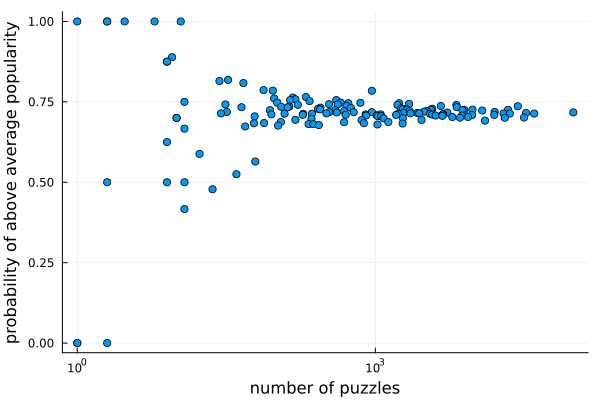

In [95]:
scatter(df4.nrow, df4.MeanHighPopularity,
        xlabel="number of puzzles",
        ylabel="probability of above average popularity",
        label=nothing,
        xaxis=:log)

How can we take into account not only deviation from the population mean of a given opening but only number of times it was played? Let me pick a simplest approach here using the `BinomialTest`. In the results we see that the results for Caro-Kann Defense are indeed most surprising.

In [96]:
df4 = @chain df begin
    @select(:OpeningFamily, :HighPopularity = :Popularity .> mean(:Popularity))
    @aside prob_high = mean(_.HighPopularity)
    groupby(:OpeningFamily)
    @combine($nrow,
             :DevMeanHighPopularity = mean(:HighPopularity) - prob_high,
             :pvalue = pvalue(BinomialTest(:HighPopularity, prob_high)))
    sort(:pvalue)
end

Row,OpeningFamily,nrow,DevMeanHighPopularity,pvalue
,String,Int64,Float64,Float64
1,Caro-Kann_Defense,27175,0.0208433,1.77125e-14
2,Philidor_Defense,12711,-0.0238896,3.3513e-9
3,Italian_Game,31430,-0.0142863,2.39405e-8
4,Catalan_Opening,923,0.0689034,2.28776e-6
5,Ruy_Lopez,20101,-0.0150326,2.69364e-6
6,Vienna_Game,6552,0.0245841,9.21446e-6
7,Kings_Indian_Defense,6610,0.0180902,0.00109228
8,Nimzo-Larsen_Attack,4567,0.0215312,0.00123113
9,Scandinavian_Defense,21695,0.00978703,0.00138542


To wrap-up our workshop let us plot the results again, now using color to highlight most surprising results.

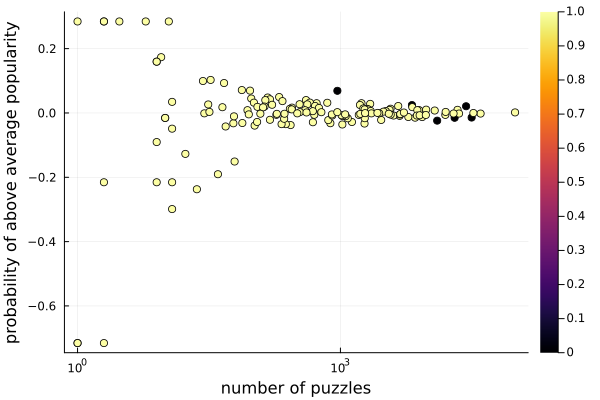

In [97]:
scatter(df4.nrow, df4.DevMeanHighPopularity,
        xlabel="number of puzzles",
        ylabel="probability of above average popularity",
        label=nothing,
        xaxis=:log,
        zcolor=df4.pvalue .> 0.001)

## Summary of available functions and macros

These rules are simplified (but hopefully easy to remember and they should be enough in practice; if you want to know all corner-cases of the syntax please refer to documentation)

| DataFrames.jl | DataFramesMeta.jl | Operation |
|:--------------|:------------------|:----------|
| `select`      | `@select`         | select/transform whole columns of source; keep number and order of columns fixed |
|               | `@rselect`        | same as `@select` but all operations are applied by row (same as `ByRow` in `select`) |
| `transform`   | `@transform`      | same as `select` but keeps all columns from the source (`:` is passed as a first argument to `select`) |
|               | `@rtransform`     | same as `@transform` but all operations are applied by row (same as `ByRow` in `transform`) |
| `select!`     | `@select!`        | same as `select` but updates parent data frame in-place |
|               | `@rselect!`       | same as `@rselect!` but updates parent data frame in-place |
| `transform!`  | `@transform!`     | same as `transform` but updates parent data frame in-place |
|               | `@rtransform!`    | same as `@rtransform!` but updates parent data frame in-place |
| `combine`     | `@combine`        | same as `select` but combines rows (e.g. produces one row from many rows); for `GroupedDataFrame` keeps order of groups |
| `subset`      | `@subset`         | subset rows of a data frame based on conditions (passing target column name is not allowed) |
|               | `@rsubset`        | same as `@subset` but all operations are applied by row (same as `ByRow` in `subset`) |
| `subset!`     | `@subset!`        | same as `subset` but updates parent data frame in-place |
|               | `@rsubset!`       | same as `@rsubset!` but updates parent data frame in-place |

General rules:
* `combine` is typically used for aggregation; because of this it does not have `r` nor `!` modifiers
* for other operations there are three funtions `select`, `transform`, and `subset` and they allow `r` and `!` modifiers

In total you need to learn 4 names (`select`, `transform`, `subset`, and `combine`) and the fact that there are three modifiers:
* `!` suffix: in place operation;
* `@` prefix: use macro instead of a function (assignment syntax using `=` instead of pair syntax using `=>`);
* `r` prefix: in macros apply all operations by row instead to whole columns.

The special feature of `subset[!]` is that it does not allow specifying target column name.

Regarding operation specification syntax the allowed styles are:

* `input columns => function => output_coumns` (full specification)
* `input column => output_coumns` (column renaming if single output column or column unnesting on multiple output columns)
* `input columns => function` (automatic generation of output column name)
* `input columns` (reuse columns "as is")
* `function` (style most useful with `do`-`end` block syntax with grouped data, function gets passed a whole data frame)

For `input columns` you can use:

* any column selector - arguments are passed as positional argument
* any column selector wrapped in `AsTable` - arguments are passed as single `NamedTuple`; for this case fast row aggregations are supported for common functions

For `output columns` you can use:

* a signle column name
* a function generating single column name
* multiple column names
* `AsTable` to automatically generate multiple column names

For `function`:

* normally function takes whole columns as positional arguments
* if source is `AsTable` it is a single `NamedTuple` of vectors
* There is a special `ByRow` wrapper which broadcasts the function over all rows
* if `function` is the only thing passed as an argument then it takes a data frame as its argument

Return value of `function`:

* normally vectors are expected to be returned and they are stored as a single column
* if a scalar is returned it is appropriately repeated if needed (a.k.a pseudo broadcasting)
* as a special rule if you want a vector to be treated as scalar wrap it in `Ref` to protect it from being spread over multiple rows 
* if multiple `output columns` are requested (by explicit vector of column names or `AsTable`) then the return value should be table-like and it gets appropriately expanded

Additionally you can pass vectors of matrices of `=>` (`Pair`) operations. This is especially convenient in combination with broadcasting.

### Afterword

DataFrames.jl 1.4 brings the following new features.

#### Change in how broadcasting assignment works

On Julia 1.7 or newer broadcasting assignment into an existing column of a data frame replaces it. Under Julia 1.6 or older it is an in place operation.

Old behavior:
```
julia> df = DataFrame(x=1:3)
3×1 DataFrame
 Row │ x
     │ Int64
─────┼───────
   1 │     1
   2 │     2
   3 │     3

julia> df.x .= 'x'
3-element Vector{Int64}:
 120
 120
 120

julia> df # people typically expect that `:x` column contains 'x' Char values after the previous operation
3×1 DataFrame
 Row │ x
     │ Int64
─────┼───────
   1 │   120
   2 │   120
   3 │   120
```

New behavior:
```
julia> df = DataFrame(x=1:3)
3×1 DataFrame
 Row │ x     
     │ Int64 
─────┼───────
   1 │     1
   2 │     2
   3 │     3

julia> df.x .= 'x'
3-element Vector{Char}:
 'x': ASCII/Unicode U+0078 (category Ll: Letter, lowercase)
 'x': ASCII/Unicode U+0078 (category Ll: Letter, lowercase)
 'x': ASCII/Unicode U+0078 (category Ll: Letter, lowercase)

julia> df
3×1 DataFrame
 Row │ x    
     │ Char 
─────┼──────
   1 │ x
   2 │ x
   3 │ x
```

#### Fully functional pivot table

`unstack` allows passing a function in valuestransform keyword argument; this allows for a convenient creation of two dimensional pivot tables.

```
julia> df = DataFrame(row=["a", "b", "b", "b"], col=["x", "x", "y", "y"], val=1:4)
4×3 DataFrame
 Row │ row     col     val   
     │ String  String  Int64 
─────┼───────────────────────
   1 │ a       x           1
   2 │ b       x           2
   3 │ b       y           3
   4 │ b       y           4

julia> unstack(df, :row, :col, :val, combine=copy)
2×3 DataFrame
 Row │ row     x        y       
     │ String  Array…?  Array…? 
─────┼──────────────────────────
   1 │ a       [1]      missing 
   2 │ b       [2]      [3, 4]

julia> unstack(df, :row, :col, :val, combine=sum)
2×3 DataFrame
 Row │ row     x       y       
     │ String  Int64?  Int64?  
─────┼─────────────────────────
   1 │ a            1  missing 
   2 │ b            2        7

julia> unstack(df, :row, :col, :val, combine=sum, fill=0)
2×3 DataFrame
 Row │ row     x      y     
     │ String  Int64  Int64 
─────┼──────────────────────
   1 │ a           1      0
   2 │ b           2      7
```

#### Full support for Base Julia opeations on rows

* row adding: `push!`, `pushfirst!`, `insert!`
* row removal: `resize!`, `keepat!`, `pop!`, `popfirst!`, `popat!`, `deleteat!`
* row reordering: `reverse`, `reverse!`, `permute!`, `invpermute!`, `shuffle`, `shuffle!`

#### Creation of data frames covering all combinations of inputs

* `allcombinations`

```
julia> allcombinations(DataFrame, a=1:2, b='a':'c')
6×2 DataFrame
 Row │ a      b
     │ Int64  Char
─────┼─────────────
   1 │     1  a
   2 │     2  a
   3 │     1  b
   4 │     2  b
   5 │     1  c
   6 │     2  c
julia> allcombinations(DataFrame, "a" => 1:2, "b" => 'a':'c', "c" => "const")
6×3 DataFrame
 Row │ a      b     c
     │ Int64  Char  String
─────┼─────────────────────
   1 │     1  a     const
   2 │     2  a     const
   3 │     1  b     const
   4 │     2  b     const
   5 │     1  c     const
   6 │     2  c     const
```

* `fillcombinations`

```
julia> df = DataFrame(x=1:2, y='a':'b', z=["x", "y"])
2×3 DataFrame
 Row │ x      y     z
     │ Int64  Char  String
─────┼─────────────────────
   1 │     1  a     x
   2 │     2  b     y
julia> fillcombinations(df, [:x, :y])
4×3 DataFrame
 Row │ x      y     z
     │ Int64  Char  String?
─────┼──────────────────────
   1 │     1  a     x
   2 │     2  a     missing
   3 │     1  b     missing
   4 │     2  b     y
julia> fillcombinations(df, [:y, :z], fill=0)
4×3 DataFrame
 Row │ x       y     z
     │ Int64?  Char  String
─────┼──────────────────────
   1 │      1  a     x
   2 │      0  b     x
   3 │      0  a     y
   4 │      2  b     y
```

#### Improved correctness of handling of threading

New `threads` argument allows disabling multithreading in `combine`, `select`, `select!`, `transform`, `transform!`, `subset` and `subset!`

#### Metadata support

Full support of various metadata annotations on table-level and column-level.

### What if I want to learn DataFrames.jl from a book?

You can check out the following resources:
* [Julia Data Science](https://juliadatascience.io/)
* [Statistics with Julia: Fundamentals for Data Science, Machine Learning and Artificial Intelligence](https://www.amazon.com/Statistics-Julia-Fundamentals-Artificial-Intelligence/dp/3030709000/)

---

Also I have written the book [Julia for Data Analysis](https://www.manning.com/books/julia-for-data-analysis) that focuses on working with DataFrames.jl.

Currently you can get it at:
* [Manning](https://www.manning.com/books/julia-for-data-analysis) website;
* all source code is available in [book's GitHub repository](https://github.com/bkamins/JuliaForDataAnalysis); you can also find there links to related video tutorials I have recorded.

### What is next?

SGH Warsaw School of Economics and MIT Julia Lab have received funding supporting further development of JuliaData ecosystem and teaching materials, so we have a bright future ahead!

*Preparation of this worksop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](logo.png)